# Part One: Exploratory Data Analysis

In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#load data
data = pd.read_json('logins.json')

In [3]:
#let's get a sense of the data we're working with
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#check for missing values
data.isnull().sum()

login_time    0
dtype: int64

In [5]:
#check for duplicate values
data.duplicated().sum()

877

In [6]:
#data types
data.dtypes

login_time    datetime64[ns]
dtype: object

In [7]:
#setting index to login time, grouping data by 15 min intervals & calculating logins in each interval
data['login_time'] = pd.to_datetime(data['login_time'])
data.set_index('login_time', inplace=True)
login_counts = data.resample('15T').size()

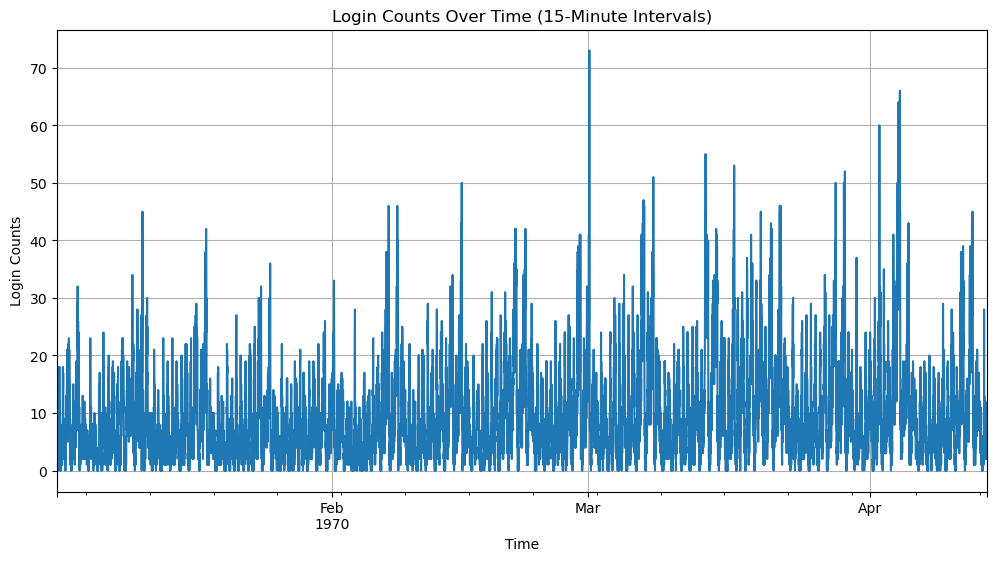

In [8]:
#visualize time-series
plt.figure(figsize=(12, 6))
login_counts.plot()
plt.title('Login Counts Over Time (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.grid(True)
plt.show()

# Part Two: Experiments & Metrics Design

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Seeing as the goal is to increase the amount of cross-city rides (rides where the pick-up and drop-off are in different cities) when there is toll re-imbursement offered, I would choose percentage of trips that are cross-city as the key.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

First, we would calculate the current percentage of trips that are cross-city, before the toll re-imbursement is offered. Then, we would need to begin the toll re-imbursement, tracking the rides pick-up & drop-off over a defined period of time. Afterwards, we can calculate the percentage of cross-city rides after the toll re-imbursement is offered, and compare it to the original percentage.

Since we are determining if there is a significance between two categorical variables (before toll re-imbursement vs. after & cross-city rides vs. non-cross-city rides), the most appropriate test would be a Chi-Square Test for Independence.

Potential caveats with this analysis is that it doesn't take into account external factors that may affect our data like local events, seasonal changes, or driver's personal preference. However, by doing this experiment and analysis, we can assess the effectiveness of the toll re-imbursement and provide actionable insights for the city operations team.

# Part Three: Predictive Modeling

In [9]:
#import necessary libraries
import pandas as pd
import json

In [10]:
#load data & convert to pandas dataframe
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

In [11]:
#let's get a sense of our data
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
#converting date columns to datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [14]:
#checking for missing values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [15]:
#filling missing ratings with avg & missing phone types with mode
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['phone'].fillna(df['phone'].mode(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

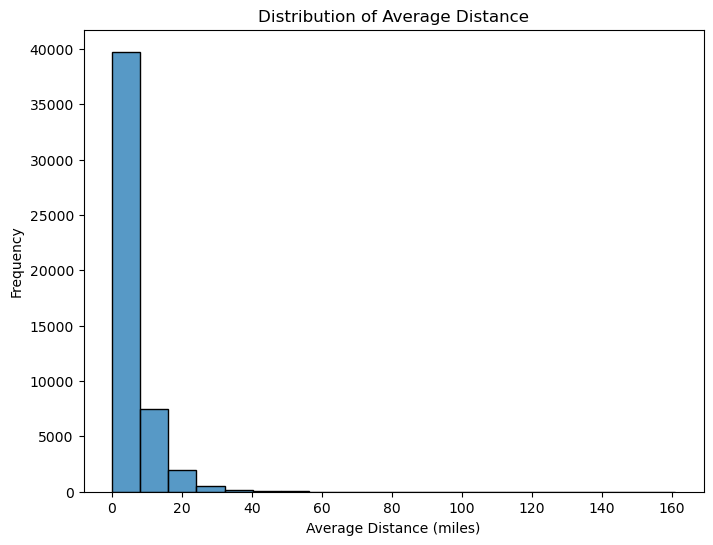

In [16]:
import seaborn as sns #for visualizations

#histogram of avg_dist
plt.figure(figsize=(8, 6))
sns.histplot(df['avg_dist'], bins=20)
plt.title('Distribution of Average Distance')
plt.xlabel('Average Distance (miles)')
plt.ylabel('Frequency')
plt.show()

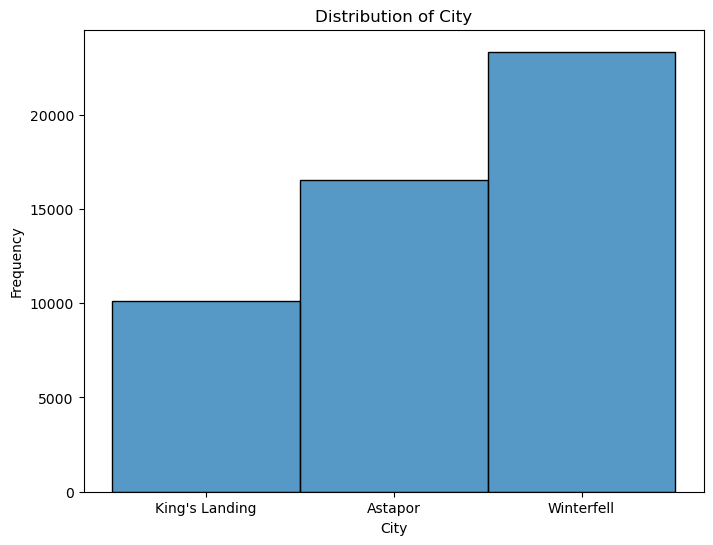

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(df['city'], bins=20)
plt.title('Distribution of City')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.show()

In [18]:
#calculating retention rate
last_date = df['last_trip_date'].max()
active_users = df[df['last_trip_date'] >= last_date - pd.Timedelta('30 days')]
retention_rate = len(active_users) / len(df)
print("Retention rate: {:.2%}".format(retention_rate))

Retention rate: 37.61%


In [19]:
#creating our target variable: retention
last_date = df['last_trip_date'].max()
df['retained'] = (df['last_trip_date'] >= last_date - pd.Timedelta('30 days')).astype(int)

In [20]:
#correlation matrix
df.corr()

/var/folders/l0/nstnpmsj4vx3h2j35yqllfcr0000gn/T/ipykernel_80613/3671392483.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
trips_in_first_30_days,1.000000,-0.011060,-0.001841,0.005720,0.112210,0.050388,-0.136329,-0.039097,0.210463
avg_rating_of_driver,-0.011060,1.000000,-0.021653,-0.003290,-0.001916,0.012587,0.028508,0.101660,-0.010829
avg_surge,-0.001841,-0.021653,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.010498,-0.003333
surge_pct,0.005720,-0.003290,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.019964,0.011797
ultimate_black_user,0.112210,-0.001916,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.009328,0.205002
weekday_pct,0.050388,0.012587,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.020366,0.009693
avg_dist,-0.136329,0.028508,-0.081491,-0.104414,0.032310,0.101652,1.000000,0.079793,-0.092780
avg_rating_by_driver,-0.039097,0.101660,0.010498,0.019964,0.009328,0.020366,0.079793,1.000000,-0.026748
retained,0.210463,-0.010829,-0.003333,0.011797,0.205002,0.009693,-0.092780,-0.026748,1.000000


/var/folders/l0/nstnpmsj4vx3h2j35yqllfcr0000gn/T/ipykernel_80613/1496801470.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')


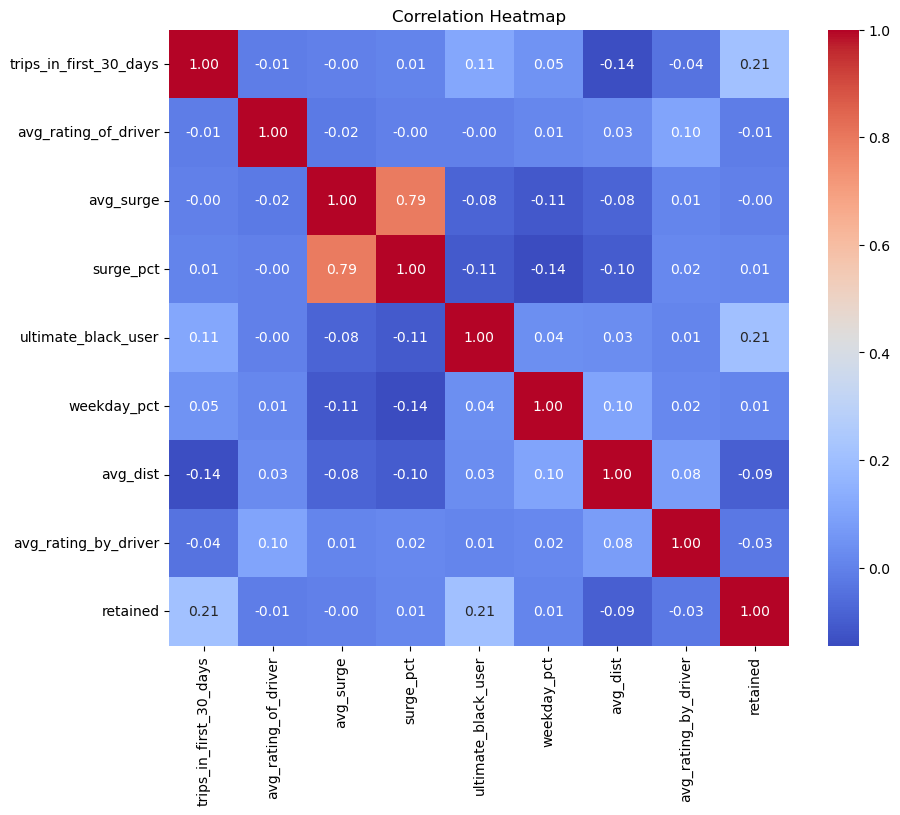

In [21]:
#my very favorite, a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Looking at the correlation matrix and heatmap we just created, we can see that the variables with the strongest correlations to our target variable are trips_in_first_30_days & ultimate_black_user, by far. Other possibly significant features include avg_dist, avg_rating_by_driver, avg_rating_of_driver, and surge_pct. Using this insight let's build our model. We will play with these features to determine which produce the best model.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

features = df[['trips_in_first_30_days', 'ultimate_black_user', 'avg_rating_by_driver', 'weekday_pct', 'avg_dist']]
target = df['retained']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print("Accuracy: {:.2%}".format(accuracy))
print("Classification Report:")
print(report)


Accuracy: 67.19%
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77      6219
           1       0.65      0.29      0.40      3781

    accuracy                           0.67     10000
   macro avg       0.66      0.60      0.59     10000
weighted avg       0.67      0.67      0.63     10000



I'm not thrilled with this accuracy rate, let's see if we can improve this.

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2']       
}

#grid search to find best parameters
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

best_predictions = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_predictions)
best_report = classification_report(y_test, best_predictions)

print("Best Model Accuracy: {:.2%}".format(best_accuracy))
print("Best Model Classification Report:")
print(best_report)

Best Model Accuracy: 67.19%
Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77      6219
           1       0.65      0.29      0.40      3781

    accuracy                           0.67     10000
   macro avg       0.66      0.60      0.59     10000
weighted avg       0.67      0.67      0.63     10000



/Users/trinaodonohoe/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/trinaodonohoe/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/trinaodonohoe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/trinaodonohoe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/

No improvement. Perhaps a different classification algorithm would be more suitable.

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#random forest model
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

print("Random Forest Model Accuracy: {:.2%}".format(rf_accuracy))
print("Random Forest Model Classification Report:")
print(rf_report)

Random Forest Model Accuracy: 68.86%
Random Forest Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      6219
           1       0.59      0.59      0.59      3781

    accuracy                           0.69     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.69      0.69      0.69     10000



In [25]:
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

best_rf_predictions = best_rf_model.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, best_rf_predictions)
best_rf_report = classification_report(y_test, best_rf_predictions)

print("Best Random Forest Model Accuracy: {:.2%}".format(best_rf_accuracy))
print("Best Random Forest Model Classification Report:")
print(best_rf_report)


Best Random Forest Model Accuracy: 73.79%
Best Random Forest Model Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      6219
           1       0.68      0.59      0.63      3781

    accuracy                           0.74     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.73      0.74      0.73     10000



Yay, improvement! Let's see if we can do even better.

In [26]:
#feature importance analysis
feature_importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                  Feature  Importance
3             weekday_pct    0.325336
2    avg_rating_by_driver    0.317672
4                avg_dist    0.136444
0  trips_in_first_30_days    0.126143
1     ultimate_black_user    0.094406


In [27]:
#subsetting features based on importance
important_features = ['weekday_pct', 'avg_rating_by_driver']
X_train_subset = X_train[important_features]
X_test_subset = X_test[important_features]

#retraining the model using only important features
best_rf_model.fit(X_train_subset, y_train)
best_rf_predictions_subset = best_rf_model.predict(X_test_subset)

subset_accuracy = accuracy_score(y_test, best_rf_predictions_subset)
subset_report = classification_report(y_test, best_rf_predictions_subset)
print("Model Accuracy using Important Features: {:.2%}".format(subset_accuracy))
print("Classification Report:")
print(subset_report)

Model Accuracy using Important Features: 74.05%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      6219
           1       0.68      0.58      0.63      3781

    accuracy                           0.74     10000
   macro avg       0.73      0.71      0.71     10000
weighted avg       0.74      0.74      0.74     10000



Using what we learned in this project, I would advise Ultimate to leverage their key features for targeted efforts. Considering one of the important features, as they related to retention, was weekday percentage, I think Ultimate should focus on weekdays' user engagement. Since they're frequently using weekday rides, this would lead me to believe their customers are largely commuters, so perhaps focusing on intiatives and engagement strategies for commuters could be useful. Another significant feature was the average ratings of riders by drivers. This could also be leveraged by creating incentive programs. Reward passengers based on the consistently high ratings they receive from their drivers, bolstering long-term user retention.